# Notebook: BERTopic to analyse the Topics

## 1. Load Packages

In [1]:
from plots import plot_topic_subplots, plot_timeseries_subplots, plot_timeseries_sentiment_subplots
from gensim.models.ldamodel import LdaModel
from bertopic import BERTopic
from gensim import corpora
import pandas as pd
import numpy as np
import random
import torch
import math
import re
import os

## 2. Constants / Setup

In [2]:
#!python -m spacy download de_core_news_sm

In [3]:
N_TOPICS = 26
RANDOM_STATE = 42
TOP_N_WORDS = 100
FONT_PATH_WORDCLOUDS = 'fonts/manrope-regular.otf'

In [4]:
DATASET_MENTIONS_PATH = "../Datasets/tweets_mentions_cleaned.csv"
DATASET_MENTIONS_IMG_PATH = "../Datasets/img_dataset_mentions/predictions_cleaned.csv"
DATASET_POLITICAL_ACCOUNTS_PATH = "../Datasets/tweets_political_accounts_cleaned.csv"
DATASET_POLITICAL_ACCOUNTS_IMG_PATH = "../Datasets/img_dataset_political_accounts/predictions_cleaned.csv"
MODEL_OUTPUT_PATH = "model"

In [5]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [6]:
current_directory = os.getcwd()
plots_directory = os.path.join(current_directory, 'plots')
if not os.path.exists(plots_directory):
    os.makedirs(plots_directory)
    
results_directory = os.path.join(current_directory, 'results')
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

wordclouds_directory = os.path.join(current_directory, 'wordclouds')
if not os.path.exists(wordclouds_directory):
    os.makedirs(wordclouds_directory)

## 3. Load Dataset

In [7]:
df_mentions = pd.read_csv(DATASET_MENTIONS_PATH)
df_mentions

Unnamed: 0.1  Unnamed: 0  \
0                  0           0   
1                  1           1   
2                  2           2   
3                  3           3   
4                  4           4   
...              ...         ...   
707236        707236      707236   
707237        707237      707237   
707238        707238      707238   
707239        707239      707239   
707240        707240      707240   

                                                     text source_party  \
0       Wichtige wissenschaftliche Erkenntnis- nun mus...          SPD   
1       @KarambaDiaby @HalleSpd @SPD_LSA Ich gratulier...          SPD   
2       @KarambaDiaby @HalleSpd @SPD_LSA Herzlichen Gl...          SPD   
3       @KarambaDiaby @HalleSpd @SPD_LSA Wann werden k...          SPD   
4           @KarambaDiaby @HalleSpd @SPD_LSA Glückwunsch.          SPD   
...                                                   ...          ...   
707236  @b_riexinger Klima oder Verkehr fast gleich......        LINKE   
707237  @b_riexinger @Linksfraktion Na ob das noch lan...        LINKE   
707238           @b_riexinger Ich wünsch Dir viel Erfolg.        LINKE   
707239  @b_riexinger Nun, da gibt es ja genügend zu tu...        LINKE   
707240  @b_riexinger Wünsche dir gutes Gelingen lieber...        LINKE   

       source_account                 date  sentiment  \
0        KarambaDiaby  2021-01-09 19:35:29          0   
1        KarambaDiaby  2021-01-09 17:09:28          0   
2        KarambaDiaby  2021-01-09 13:16:13          0   
3        KarambaDiaby  2021-01-09 12:32:40          1   
4        KarambaDiaby  2021-01-09 12:13:06          0   
...               ...                  ...        ...   
707236    b_riexinger  2021-12-17 08:19:23          1   
707237    b_riexinger  2021-12-17 08:18:07          1   
707238    b_riexinger  2021-12-17 07:47:59          0   
707239    b_riexinger  2021-12-17 02:07:26          2   
707240    b_riexinger  2021-12-17 01:02:05          0   

                                             cleaned_text  
0       wichtig wissenschaftlich erkenntnis schnell pr...  
1                                       gratulieren linke  
2                             herzlich glückwunsch erfolg  
3         wann konkret massiv steuer sozialabgabe senk...  
4                                             glückwunsch  
...                                                   ...  
707236       klima verkehr fast gleich hauptsach pöstchen  
707237    na lange gut gruppierung querdenker linke bü...  
707238                                      wünsch erfolg  
707239                           genügend tu paris machen  
707240       wünsche gut gelingen lieber bernd linkspower  

[707241 rows x 8 columns]

In [8]:
df_political_accounts_img = pd.read_csv(DATASET_POLITICAL_ACCOUNTS_IMG_PATH)
df_political_accounts_img

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
0                 0             0             0           0   
1                 1             2             2           2   
2                 2             3             3           3   
3                 3             5             5           5   
4                 4             7             7           7   
...             ...           ...           ...         ...   
11812         11812         21954         21954       21954   
11813         11813         21955         21955       21955   
11814         11814         21956         21956       21956   
11815         11815         21957         21957       21957   
11816         11816         21958         21958       21958   

                  tweet_id  image_index                   filename  \
0      1377157230630301700            0  1377157230630301700_0.jpg   
1      1379754099609047040            0  1379754099609047040_0.jpg   
2      1381254353336606721            0  1381254353336606721_0.jpg   
3      1382230126335787010            0  1382230126335787010_0.jpg   
4      1384060815792230401            0  1384060815792230401_0.jpg   
...                    ...          ...                        ...   
11812  1350695518536683524            0  1350695518536683524_0.jpg   
11813  1351083430218493953            0  1351083430218493953_0.jpg   
11814  1352556008934137858            0  1352556008934137858_0.jpg   
11815  1462488643638108170            0  1462488643638108170_0.jpg   
11816  1472498789122514945            0  1472498789122514945_0.jpg   

                                                    text  \
0      Behördenwillkür\n\n\C\n\nD Es wird Zeit, den B...   
1      IREBSSWEE Folgen\n\n* So geht es nicht weiter!...   
2      6% Die Landesvorsitzende der AfD\nBerlin kriti...   
3      Corona & Bürgerrechte\n\nBl Keihe Zweiklasseng...   
4      Mietendeckel-Chaos\n\nMüllers klägliches Versa...   
...                                                  ...   
11812  Deutsches\nRotes\nKreuz\n\nServiceportal zur I...   
11813  Deutschland droht der Mega-Lockdown -\n\nobwoh...   
11814           ‚ . Die verlorene\nSchülergeneration\n\n   
11815  zur Impfpflicht! B |\n\nTino Chrupalla Bundess...   
11816                                      Alice Weide\n   

                                                     url  \
0      https://pbs.twimg.com/media/ExylKvEU8AgowSU?fo...   
1      https://pbs.twimg.com/media/EyXfBlTWEAEfrHg?fo...   
2      https://pbs.twimg.com/media/EyszgrWXEAEqXID?fo...   
3      https://pbs.twimg.com/media/Ey6q6KCWQAE9uFY?fo...   
4      https://pbs.twimg.com/media/EzUr8s8VUAIcY51?fo...   
...                                                  ...   
11812  https://pbs.twimg.com/media/Er6iaV7XAAIkOIp?fo...   
11813  https://pbs.twimg.com/media/EsADN8IXAAAnR7o?fo...   
11814  https://pbs.twimg.com/media/EsU-hOsXYAAQyIO?fo...   
11815  https://pbs.twimg.com/media/FEvNqgDWUAUD_5i?fo...   
11816  https://pbs.twimg.com/media/FG9dwrcXIAUF5BP?fo...   

                                              image_path source_party  \
0      ../Datasets/img_dataset_political_accounts/AFD...          AFD   
1      ../Datasets/img_dataset_political_accounts/AFD...          AFD   
2      ../Datasets/img_dataset_political_accounts/AFD...          AFD   
3      ../Datasets/img_dataset_political_accounts/AFD...          AFD   
4      ../Datasets/img_dataset_political_accounts/AFD...          AFD   
...                                                  ...          ...   
11812  ../Datasets/img_dataset_political_accounts/AFD...          AFD   
11813  ../Datasets/img_dataset_political_accounts/AFD...          AFD   
11814  ../Datasets/img_dataset_political_accounts/AFD...          AFD   
11815  ../Datasets/img_dataset_political_accounts/AFD...          AFD   
11816  ../Datasets/img_dataset_political_accounts/AFD...          AFD   

       source_account                 date  prediction  \
0           AfDBerlin  2021-03-3

In [9]:
df_politicians = pd.read_csv(DATASET_POLITICAL_ACCOUNTS_PATH)
df_politicians

Unnamed: 0.1  Unnamed: 0  UserScreenName  source_account  \
0                 0           0      AfD Berlin       AfDBerlin   
1                 1           1      AfD Berlin       AfDBerlin   
2                 2           2      AfD Berlin       AfDBerlin   
3                 3           3      AfD Berlin       AfDBerlin   
4                 4           4      AfD Berlin       AfDBerlin   
...             ...         ...             ...             ...   
58859         58859       58859  Tino Chrupalla  Tino_Chrupalla   
58860         58860       58860  Tino Chrupalla  Tino_Chrupalla   
58861         58861       58861  Tino Chrupalla  Tino_Chrupalla   
58862         58862       58862  Tino Chrupalla  Tino_Chrupalla   
58863         58863       58863  Tino Chrupalla  Tino_Chrupalla   

                      date                                               Text  \
0      2021-03-26 21:07:22                AfD Berlin\n@AfDBerlin\n·\n26. März   
1      2021-03-27 07:20:27                AfD Berlin\n@AfDBerlin\n·\n27. März   
2      2021-03-31 07:14:04                AfD Berlin\n@AfDBerlin\n·\n31. März   
3      2021-04-01 14:29:00                 AfD Berlin\n@AfDBerlin\n·\n1. Apr.   
4      2021-04-01 05:02:10                 AfD Berlin\n@AfDBerlin\n·\n1. Apr.   
...                    ...                                                ...   
58859  2021-12-04 17:26:46   Tino Chrupalla\n@Tino_Chrupalla\n·\n4. Dez. 2021   
58860  2021-12-13 16:30:19  Tino Chrupalla\n@Tino_Chrupalla\n·\n13. Dez. 2021   
58861  2021-12-17 14:02:24  Tino Chrupalla\n@Tino_Chrupalla\n·\n17. Dez. 2021   
58862  2021-12-19 09:27:23  Tino Chrupalla\n@Tino_Chrupalla\n·\n19. Dez. 2021   
58863  2021-12-23 13:40:49  Tino Chrupalla\n@Tino_Chrupalla\n·\n23. Dez. 2021   

                                                    text Emojis Comments  \
0      AfD wirkt.\n\nSchluss mit dem #Gendergaga\nMDR...    NaN      4.0   
1      Im Herbst wird gewählt.\nSchluss mit den Recht...    NaN     10.0   
2      Behördenwillkür\nFlüchtlingsheime durchgedrück...    NaN      3.0   
3      Aus Raider wird jetzt Twix \n\nLeider kein #Ap...    NaN      1.0   
4      Gendern geht („*innen“)\nImpfen geht nicht.\nD...    NaN      1.0   
...                                                  ...    ...      ...   
58859  Friedlicher Protest gegen einen #Impfzwang ist...    NaN    265.0   
58860  @OlafScholz\n muss sich endlich klar zu Nord S...    NaN      4.0   
58861  Mit \n@_FriedrichMerz\n gibt es keine konserva...    NaN    188.0   
58862  Wir wünschen Ihnen und Ihrer Familie einen bes...    NaN    449.0   
58863  @_FriedrichMerz\n will parlamentarische Zusamm...    NaN      9.0   

       Likes Retweets                                             photos  \
0       28.0    132.0  ['https://pbs.twimg.com/profile_images/1037343...   
1       20.0    112.0  ['https://pbs.twimg.com/card_img/1471780757332...   
2       13.0     34.0  ['https://pbs.twimg.com/media/ExylKvEU8AgowSU?...   
3        4.0     17.0  ['https://pbs.twimg.com/card_img/1472910546907...   
4        3.0     16.0  ['https://pbs.twimg.com/profile_images/9706413...   
...      ...      ...                                                ...   
58859  122.0    578.0                                                 []   
58860    2.0     11.0                                                 []   
58861  227.0    1.008                                                 []   
58862  346.0    2.648  ['https://pbs.twimg.com/media/FG9dwrcXIAUF5BP?...   
58863    4.0     11.0  ['https://pbs.twimg.com/card_img/1481535392549...   

                                               Tweet URL     id source_party  \
0      https://twitter.com/AfDBerlin/status/137555499...      1          AFD   
1      https://twitter.com/AfDBerlin/status/137570928...      2          AFD   
2      https://twitter.com/AfDBerlin/status/137715723...      3          AFD   
3      https://twitter.com/AfDBerlin/status/137762907...      4          AFD   
4  

In [10]:
df_mentions_img = pd.read_csv(DATASET_MENTIONS_IMG_PATH)
df_mentions_img

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0             tweet_id  \
0                 0             1           1  1345863370579320832   
1                 1             2           2  1345860999602184196   
2                 2             3           3  1345841888289550345   
3                 3             4           4  1345840672113373186   
4                 4             6           6  1345831938725183491   
...             ...           ...         ...                  ...   
26366         26366         34133       34133  1418243452920377346   
26367         26367         34134       34134  1422195119621656576   
26368         26368         34135       34135  1438112331666530313   
26369         26369         34138       34138  1444703262951759880   
26370         26370         34139       34139  1446709991805751297   

       image_index                   filename  \
0                0  1345863370579320832_0.jpg   
1                0  1345860999602184196_0.jpg   
2                0  1345841888289550345_0.jpg   
3                0  1345840672113373186_0.jpg   
4                0  1345831938725183491_0.jpg   
...            ...                        ...   
26366            0  1418243452920377346_0.jpg   
26367            0  1422195119621656576_0.jpg   
26368            0  1438112331666530313_0.jpg   
26369            0  1444703262951759880_0.jpg   
26370            0  1446709991805751297_0.jpg   

                                                    text  \
0                                 Asyl- |\nmißbrauch\n\n   
1      kann, dass dieses '\n\nGesindel\n\nwieder vers...   
2      25. Februar 2011, 11:45 Uhr FDPrudert zurück\n...   
3      You can fool some of the people all of the tim...   
4                                  #teamLaschetSpahn\n\n   
...                                                  ...   
26366                7 O FRAGENAN\nBERND-RIEXINGER -\n\n   
26367  MSCI WORLD INDEX CHART - MAX EERETIEITUEELTRT ...   
26368            Gemeinsam mache:\ndas Land gerecht.\n\n   
26369  Zusammenhalten.\nFür Gerechtigkeit.\nDIE LINKE.\n   
26370  Das umgekehrte Bild bei der\n\nLinken: Sie ver...   

                                                   url  \
0      https://pbs.twimg.com/media/Eq13meUXEAMWanr.jpg   
1      https://pbs.twimg.com/media/Eq11cdkW8AU8leb.jpg   
2      https://pbs.twimg.com/media/Eq1kEA2XUAAyW_f.jpg   
3      https://pbs.twimg.com/media/Eq1i03_W4AANqWe.png   
4      https://pbs.twimg.com/media/Eq1bAfuXcAAqx2p.png   
...                                                ...   
26366  https://pbs.twimg.com/media/E66c54tXoAA661Y.jpg   
26367  https://pbs.twimg.com/media/E7ym6EuX0AkEFJR.png   
26368  https://pbs.twimg.com/media/E_UzhLxXsAEE-dR.jpg   
26369  https://pbs.twimg.com/media/FAyahiCXoAI6Kzy.jpg   
26370  https://pbs.twimg.com/media/FBO-9t7WEAkN-fA.jpg   

                                              image_path source_party  \
0      ../Datasets/img_dataset_mentions/CDU_CSU/Armin...      CDU_CSU   
1      ../Datasets/img_dataset_mentions/CDU_CSU/Armin...      CDU_CSU   
2      ../Datasets/img_dataset_mentions/CDU_CSU/Armin...      CDU_CSU   
3      ../Datasets/img_dataset_mentions/CDU_CSU/Armin...      CDU_CSU   
4      ../Datasets/img_dataset_mentions/CDU_CSU/Armin...      CDU_CSU   
...                                                  ...          ...   
26366  ../Datasets/img_dataset_mentions/LINKE/b_riexi...        LINKE   
26367  ../Datasets/img_dataset_mentions/LINKE/b_riexi...        LINKE   
26368  ../Datasets/img_dataset_mentions/LINKE/b_riexi...        LINKE   
26369  ../Datasets/img_dataset_mentions/LINKE/b_riexi...        LINKE   
26370  ../Datasets/img_dataset_mentions/LINKE/b_riexi...        LINKE   

      source_account                 date  prediction  \
0       ArminLaschet  2021-01-03 22:43:27           1   
1       ArminLaschet  2021-01-03 22:34:01           1   
2       ArminLaschet  2021-01-03 21:18:05           2   
3       ArminLaschet  2021-01-03 21:13:15           2 

## 4. Code

#### Clean Data

In [11]:
df = df_politicians.copy()

In [12]:
df['date'] = pd.to_datetime(df['date'])
months = df['date'].dt.month.to_list()

In [13]:
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: '' if type(x) != str else x)

In [14]:
cleaned_text = df.cleaned_text.to_list()

#### Train BERTopic

In [15]:
from umap import UMAP

# These are the default parameters (see here: https://github.com/MaartenGr/BERTopic/blob/15ea0cd804d35c1f11c6692f33c3666b648dd6c8/bertopic/_bertopic.py#L156-L160) but additionally, I added a random state
umap_model = UMAP(n_neighbors=15, n_components=5, 
                  min_dist=0.0, metric='cosine', random_state=RANDOM_STATE)

In [16]:
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# hdbscan_model = HDBSCAN(min_cluster_size=25, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
hdbscan_model = HDBSCAN(metric='euclidean', cluster_selection_method='eom', prediction_data=True, min_cluster_size=int(len(df)/200), min_samples=5)
#hdbscan_model = AgglomerativeClustering(n_clusters=50)

In [17]:
model = BERTopic(language="german", hdbscan_model=hdbscan_model, nr_topics=N_TOPICS, umap_model=umap_model, top_n_words=TOP_N_WORDS)

In [18]:
topics, probabilities = model.fit_transform(cleaned_text)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [19]:
topics = model.reduce_outliers(cleaned_text, topics, strategy="distributions")

In [20]:
model.update_topics(cleaned_text, topics, top_n_words=TOP_N_WORDS)

In [21]:
topics_over_time = model.topics_over_time(cleaned_text, months)

In [23]:
n_topics = N_TOPICS - 1
document_info = model.get_document_info(cleaned_text)
topics_over_time["Name"] = topics_over_time["Topic"].apply(lambda x: document_info[document_info["Topic"] == x]["Name"].iloc[0])
document_info["date"] = df["date"]
if 'sentiment' in df.columns:
    document_info["sentiment"] = df["sentiment"]
document_info["month"] = df['date'].dt.month

In [24]:
model.get_document_info(cleaned_text)[model.get_document_info(cleaned_text)["Topic"] == 1]

Document  Topic  \
1      herbst wählen schluss rechtsbrüch regierung bi...      1   
3      raider twix leider aprilscherz bz berlin neu n...      1   
4      gender innen impfe regierung blamieren deutsch...      1   
6      top manager nutzen afd argument kritik versage...      1   
14     forscher stellen seit monat aufgestellt forder...      1   
...                                                  ...    ...   
58853    regel scheitern freiheitsentzug ungeimpft co...      1   
58854  beteuert merkel spahn söder impfpflicht lässen...      1   
58855  cdu mp allg impfpflicht obwohl impfstoff immun...      1   
58856  diskussion lockdown impfpflicht müssen umgehen...      1   
58857  urteil bverfg bundesnotbremse enttäuschend ent...      1   

                                      Name  \
1      1_corona_impfstoff_pandemie_impfung   
3      1_corona_impfstoff_pandemie_impfung   
4      1_corona_impfstoff_pandemie_impfung   
6      1_corona_impfstoff_pandemie_impfung   
14     1_corona_impfstoff_pandemie_impfung   
...                                    ...   
58853  1_corona_impfstoff_pandemie_impfung   
58854  1_corona_impfstoff_pandemie_impfung   
58855  1_corona_impfstoff_pandemie_impfung   
58856  1_corona_impfstoff_pandemie_impfung   
58857  1_corona_impfstoff_pandemie_impfung   

                                             Top_n_words  Probability  \
1      corona - impfstoff - pandemie - impfung - impf...     0.000000   
3      corona - impfstoff - pandemie - impfung - impf...     0.943233   
4      corona - impfstoff - pandemie - impfung - impf...     1.000000   
6      corona - impfstoff - pandemie - impfung - impf...     0.000000   
14     corona - impfstoff - pandemie - impfung - impf...     1.000000   
...                                                  ...          ...   
58853  corona - impfstoff - pandemie - impfung - impf...     1.000000   
58854  corona - impfstoff - pandemie - impfung - impf...     1.000000   
58855  corona - impfstoff - pandemie - impfung - impf...     1.000000   
58856  corona - impfstoff - pandemie - impfung - impf...     1.000000   
58857  corona - impfstoff - pandemie - impfung - impf...     1.000000   

       Representative_document  
1                        False  
3                        False  
4                        False  
6                        False  
14                       False  
...                        ...  
58853                    False  
58854                    False  
58855                    False  
58856                    False  
58857                    False  

[9539 rows x 6 columns]

In [95]:
#pd.DataFrame.from_dict(topic_counts, orient='index', columns=['Frequency'])
topic_statistics = model.get_document_info(cleaned_text)["Topic"].value_counts().reset_index().rename(columns={"index": "Topic", "Topic": "Frequency"}).sort_values("Topic").reset_index(drop=True)
topic_statistics = topic_statistics[topic_statistics["Topic"] != -1]
topic_statistics["Topic"] = topic_statistics["Topic"] + 1
topic_statistics

Topic  Frequency
1       1      16544
2       2       9539
3       3       4764
4       4       2959
5       5       1915
6       6       1348
7       7       1691
8       8       2191
9       9       1153
10     10       1018
11     11       1582
12     12       1199
13     13       1336
14     14        800
15     15       1460
16     16       1513
17     17       1378
18     18        715
19     19       1061
20     20        829
21     21        634
22     22       1034
23     23        480
24     24        978
25     25        610

## Store topics as Latex

In [96]:
top_words = []
for topic in topic_statistics["Topic"]:
    words = model.get_topic(topic - 1)[:3]
    top_words.append(', '.join([word[0] for word in words]))
    
topic_statistics["Top Words"] = top_words
topic_statistics

Topic  Frequency                               Top Words
1       1      16544                  afd, berlin, bundestag
2       2       9539             corona, impfstoff, pandemie
3       3       4764              klimaschutz, klima, sozial
4       4       2959                     euro, rente, steuer
5       5       1915                   kind, schule, familie
6       6       1348        afghanistan, bundeswehr, taliban
7       7       1691                youtube, live, musiktipp
8       8       2191                   grüne, grün, baerbock
9       9       1153                  belarus, polen, grenze
10     10       1018            israel, antisemitismus, jude
11     11       1582         digital, digitalisierung, thema
12     12       1199                   frau, gender, sprache
13     13       1336               polizei, polizist, werden
14     14        800          landwirtschaft, wald, klöckner
15     15       1460                  europa, eu, europäisch
16     16       1513        freiheit, verfassungsschutz, afd
17     17       1378                  csu, cdu, abgeordneter
18     18        715                russland, nawalny, putin
19     19       1061                  twitter, tweet, source
20     20        829               hochwasser, hilfe, mensch
21     21        634                     fußball, spiel, hsv
22     22       1034             arbeit, lohn, beschäftigter
23     23        480           rassismus, hanau, rassistisch
24     24        978  journalist, pressefreiheit, öffentlich
25     25        610                   gedenken, nazi, opfer

In [113]:
topic_statistics_extended = pd.concat([topic_statistics[0:13].reset_index(drop=True), topic_statistics[13:25].reset_index(drop=True)], axis=1).reset_index(drop=True)
print(topic_statistics_extended.to_latex(index=False))

\begin{tabular}{rrlrrl}
\toprule
 Topic &  Frequency &                        Top Words &  Topic &  Frequency &                              Top Words \\
\midrule
     1 &      16544 &           afd, berlin, bundestag &   14.0 &      800.0 &         landwirtschaft, wald, klöckner \\
     2 &       9539 &      corona, impfstoff, pandemie &   15.0 &     1460.0 &                 europa, eu, europäisch \\
     3 &       4764 &       klimaschutz, klima, sozial &   16.0 &     1513.0 &       freiheit, verfassungsschutz, afd \\
     4 &       2959 &              euro, rente, steuer &   17.0 &     1378.0 &                 csu, cdu, abgeordneter \\
     5 &       1915 &            kind, schule, familie &   18.0 &      715.0 &               russland, nawalny, putin \\
     6 &       1348 & afghanistan, bundeswehr, taliban &   19.0 &     1061.0 &                 twitter, tweet, source \\
     7 &       1691 &         youtube, live, musiktipp &   20.0 &      829.0 &              hochwasser, hilfe, 

In [26]:
import pandas as pd

df_topics = pd.DataFrame()

for i in range(n_topics):
    topic = model.get_topic(i)
    words = [word[0] for word in topic]
    scores = [word[1] for word in topic]
    
    df_topics[f"topic_{i}_word"] = words
    df_topics[f"topic_{i}_score"] = scores

df_topics.to_csv("results/topic_scores.csv")
df_topics

topic_0_word  topic_0_score topic_1_word  topic_1_score topic_2_word  \
0               afd       0.026549       corona       0.042454  klimaschutz   
1            berlin       0.023044    impfstoff       0.019660        klima   
2         bundestag       0.020827     pandemie       0.019645       sozial   
3               cdu       0.016949      impfung       0.019134   klimakrise   
4           antwort       0.015974       impfen       0.018707          bei   
..              ...            ...          ...            ...          ...   
95         sprechen       0.004508         seit       0.004752     schützen   
96           linker       0.004497          jan       0.004735      schnell   
97            dafür       0.004494         groß       0.004733        geben   
98          kämpfen       0.004487       schutz       0.004720          afd   
99  kanzlerkandidat       0.004477        dafür       0.004714     aufbruch   

    topic_2_score topic_3_word  topic_3_score topic_4_word  topic_4_score  \
0        0.051794         euro       0.038962         kind       0.087505   
1        0.021494        rente       0.031593       schule       0.064339   
2        0.020850       steuer       0.023005      familie       0.031174   
3        0.016197       scholz       0.019779  jugendliche       0.026114   
4        0.016050  deutschland       0.019642       corona       0.021737   
..            ...          ...            ...          ...            ...   
95       0.005088        hartz       0.005442    schülerin       0.005128   
96       0.005025      gerecht       0.005349   erwachsene       0.005128   
97       0.005003        statt       0.005261         hoch       0.005111   
98       0.005001     deutlich       0.005246  deutschland       0.005090   
99       0.005000           ab       0.005242          tun       0.005082   

    ... topic_20_word  topic_20_score    topic_21_word  topic_21_score  \
0   ...       fußball        0.050383           arbeit        0.055664   
1   ...         spiel        0.043356             lohn        0.036040   
2   ...           hsv        0.040013    beschäftigter        0.031760   
3   ...     nurderhsv        0.033572              gut        0.030566   
4   ...         sport        0.033440     arbeitsmarkt        0.025937   
..  ...           ...             ...              ...             ...   
95  ...         arena        0.006590  sozialpolitisch        0.006017   
96  ...      sportler        0.006566           ändern        0.006014   
97  ...         pauli        0.006468         schlecht        0.005987   
98  ...          gold        0.006321        bundestag        0.005874   
99  ...       zweiter        0.006287       ausbildung        0.005807   

            topic_22_word  topic_22_score   topic_23_word  topic_23_score  \
0               rassismus        0.116683      journalist        0.046415   
1                   hanau        0.083989  pressefreiheit        0.031547   
2             rassistisch        0.065671      öffentlich        0.030677   
3            gesellschaft        0.034324            hass        0.027962   
4                anschlag        0.032164            netz        0.021057   
..                    ...             ...             ...             ...   
95              hautfarbe        0.006528              ab        0.004934   
96                 stehen        0.006518       versuchen        0.004912   
97  menschenfeindlichkeit        0.006491          renate        0.004886   
98                  innen        0.006470             mai        0.004882   
99                schwarz        0.006438        bedrohen        0.004875   

    topic_24_word  topic_24_score  
0        gedenken        0.064785  
1            nazi        0.063815  
2           opfer        0.046629  
3            jahr        0.036457  
4        erinnern        0.034227  
..            ...             ...  
95          daran        0.006589  
96         probst        0.0065

16544


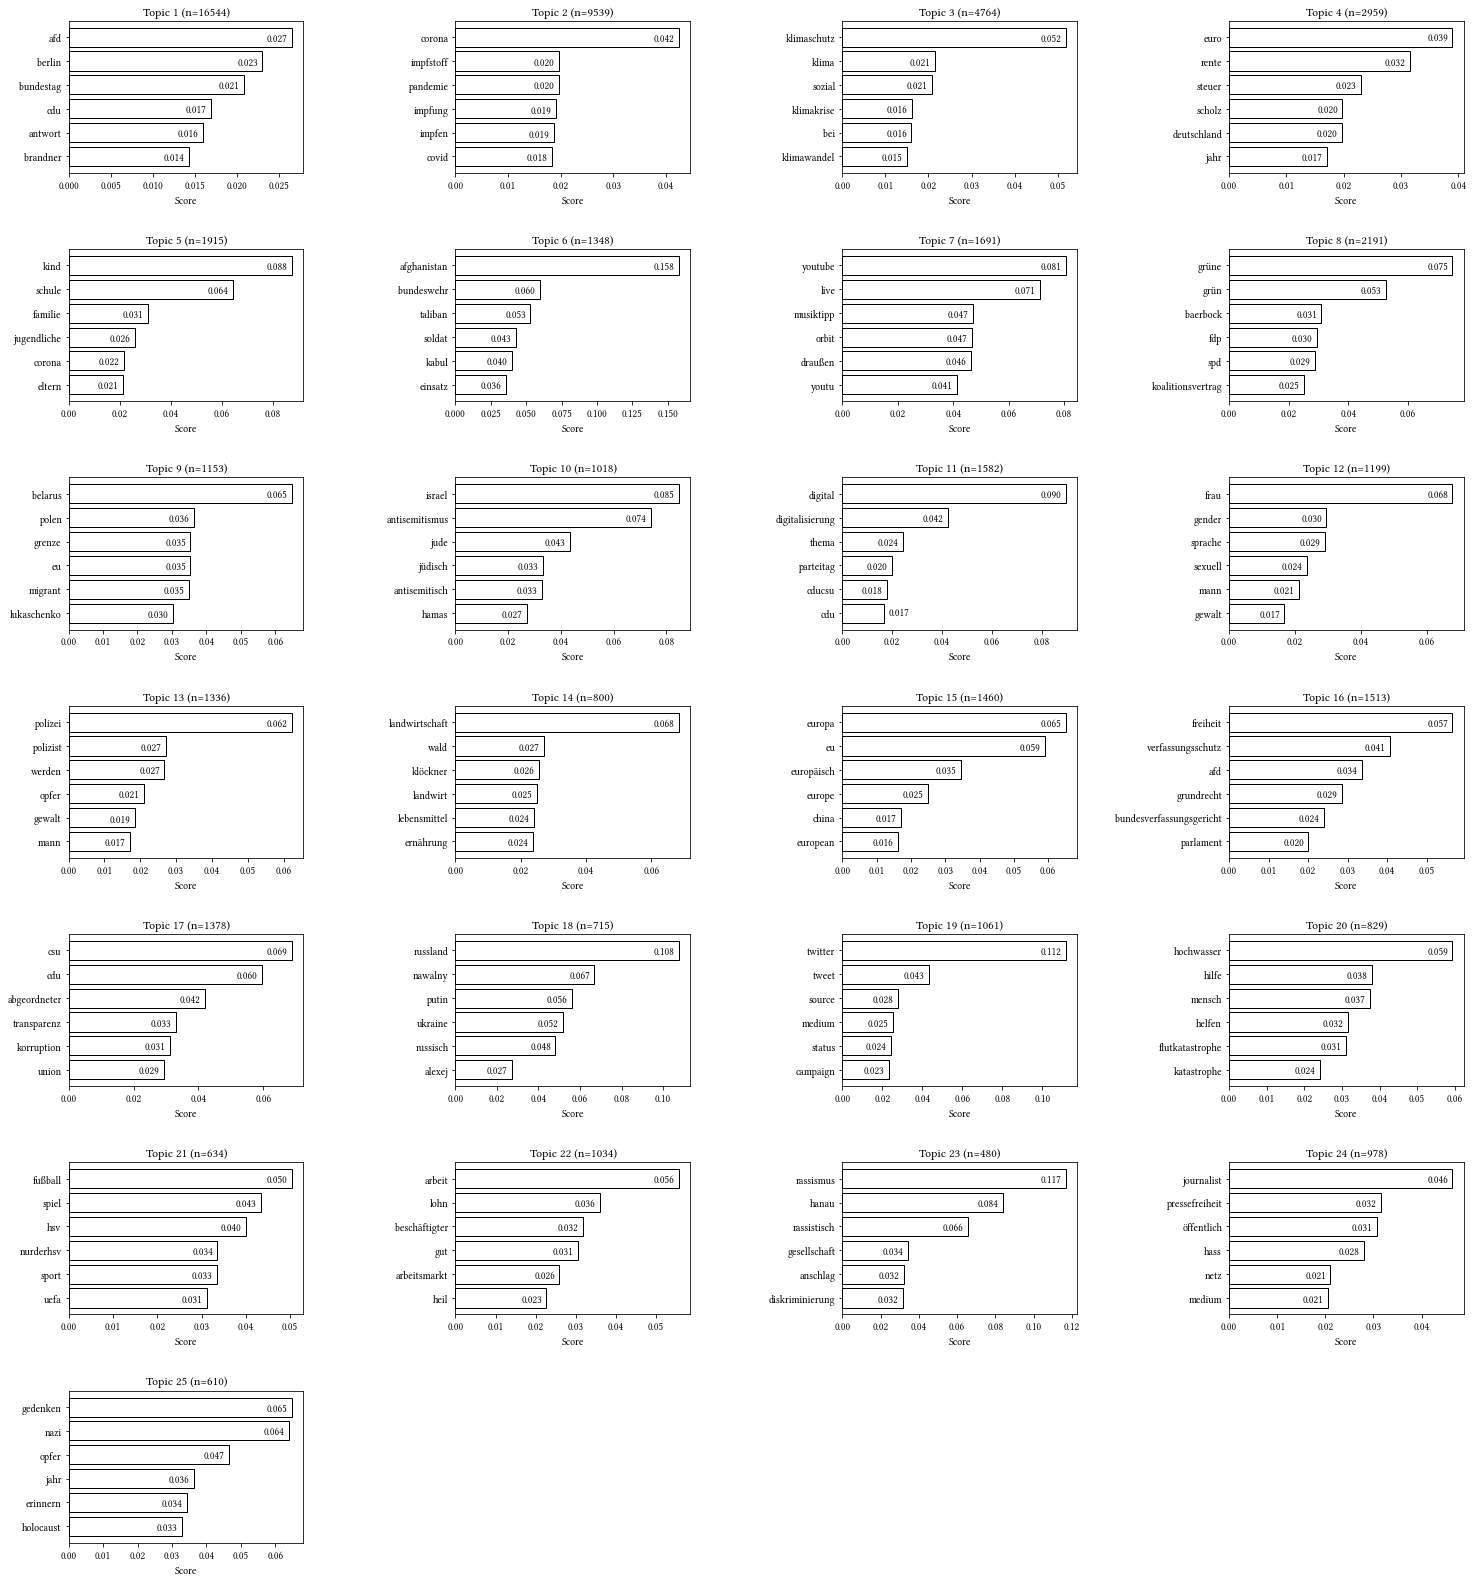

In [27]:
plot_topic_subplots(df_topics, n_topics, document_info["Topic"].value_counts(), filename="results/top5_topics")

A ward linkage function is used to perform the hierarchical clustering based on the cosine distance matrix between topic embeddings.

In [28]:
fig = model.visualize_hierarchy(width=2000, height=2000)
fig.write_html("results/hirachy.html")

Visualize a heatmap of the topic's similarity matrix. Based on the cosine similarity matrix between topic embeddings, a heatmap is created showing the similarity between topics.

In [29]:
fig = model.visualize_heatmap(width=2000, height=2000)#(cleaned_text)
fig.write_html("results/heatmap.html")

### Topics over time

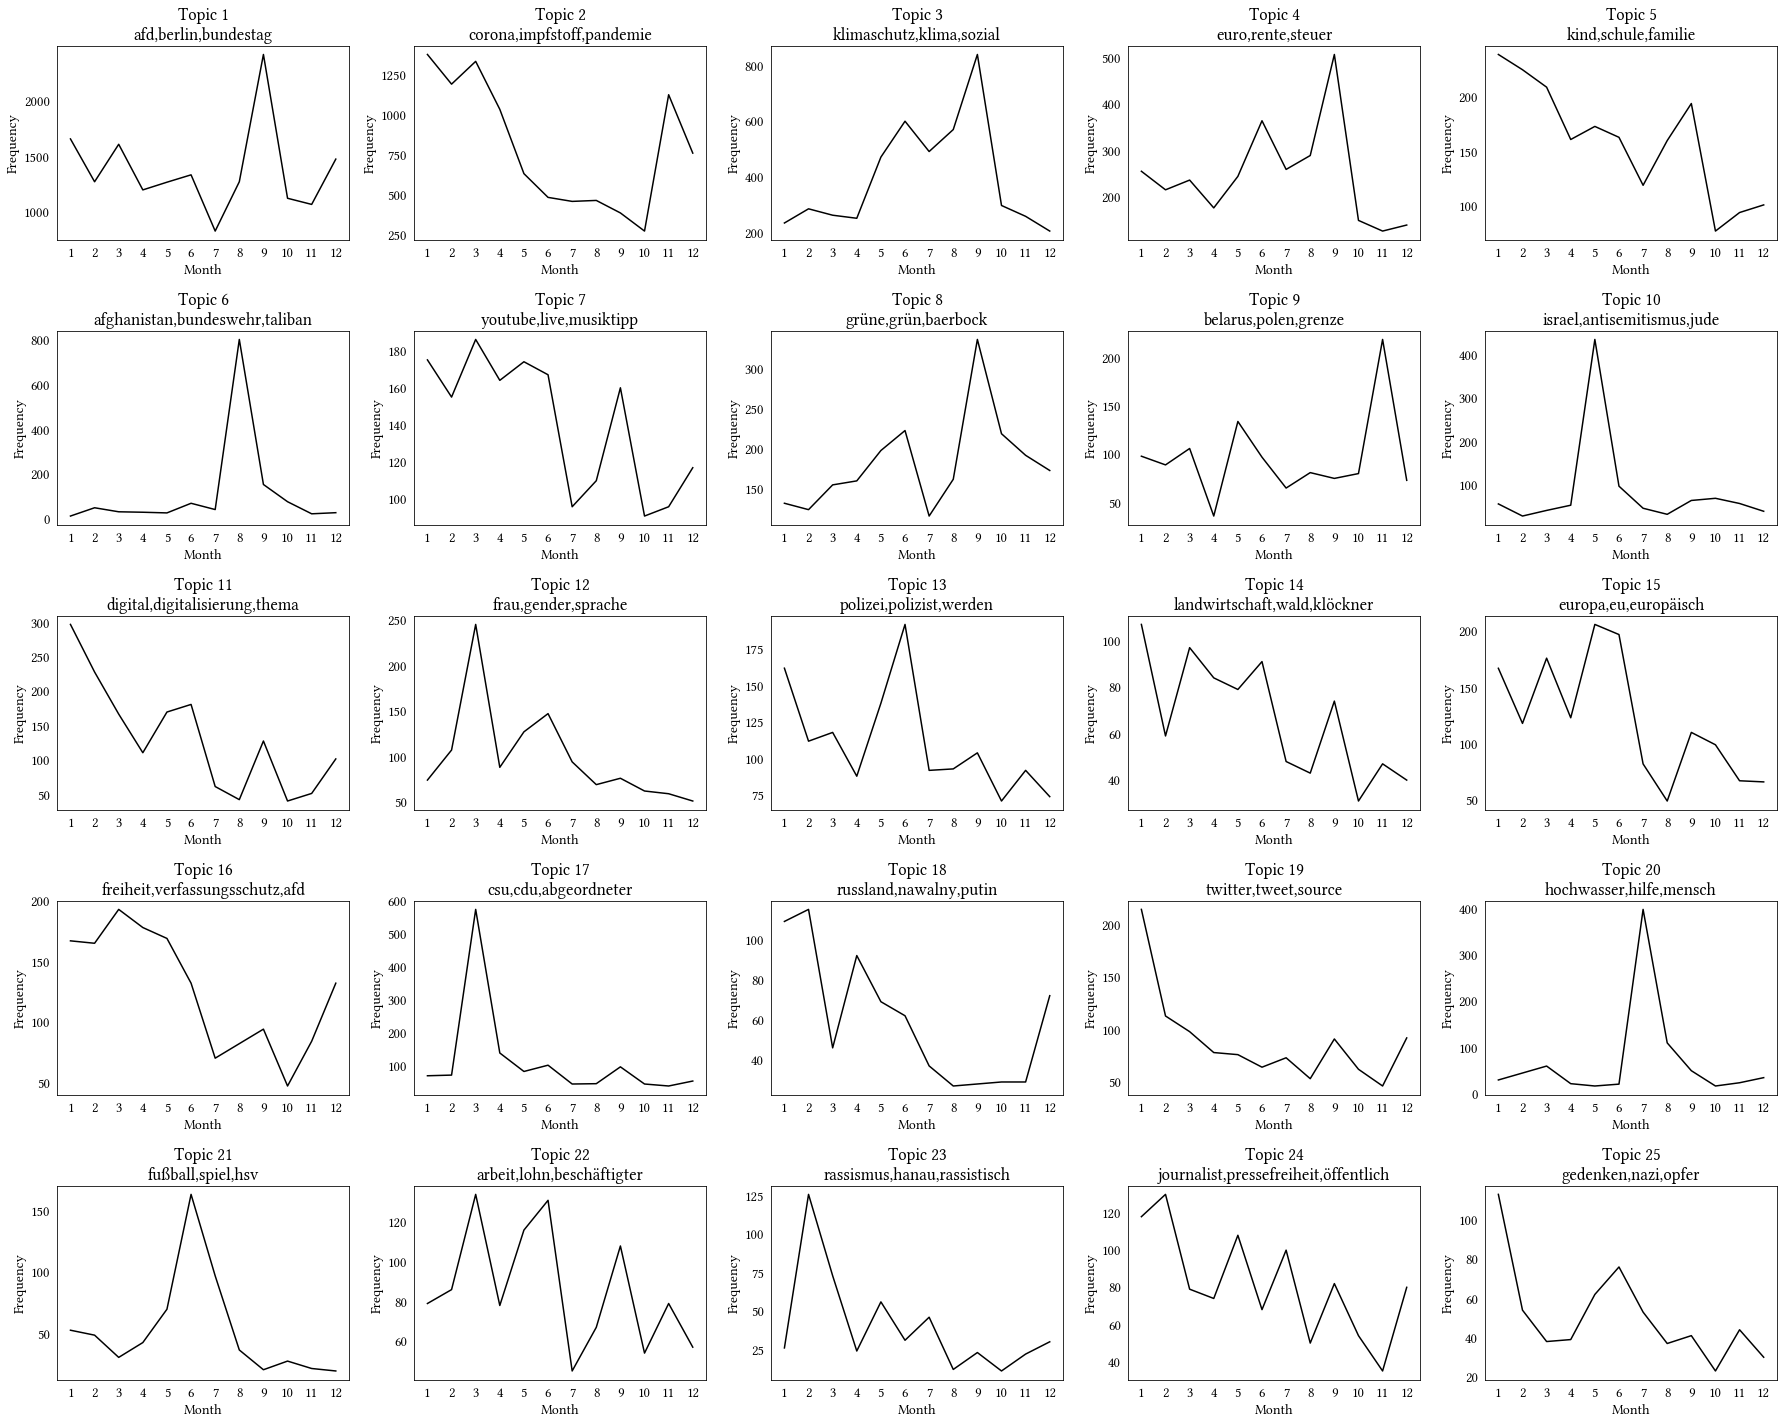

In [30]:
plot_timeseries_subplots(df_topics, n_topics, topics_over_time, filename="results/timeseries_topics")

#### Sentiment Over Time

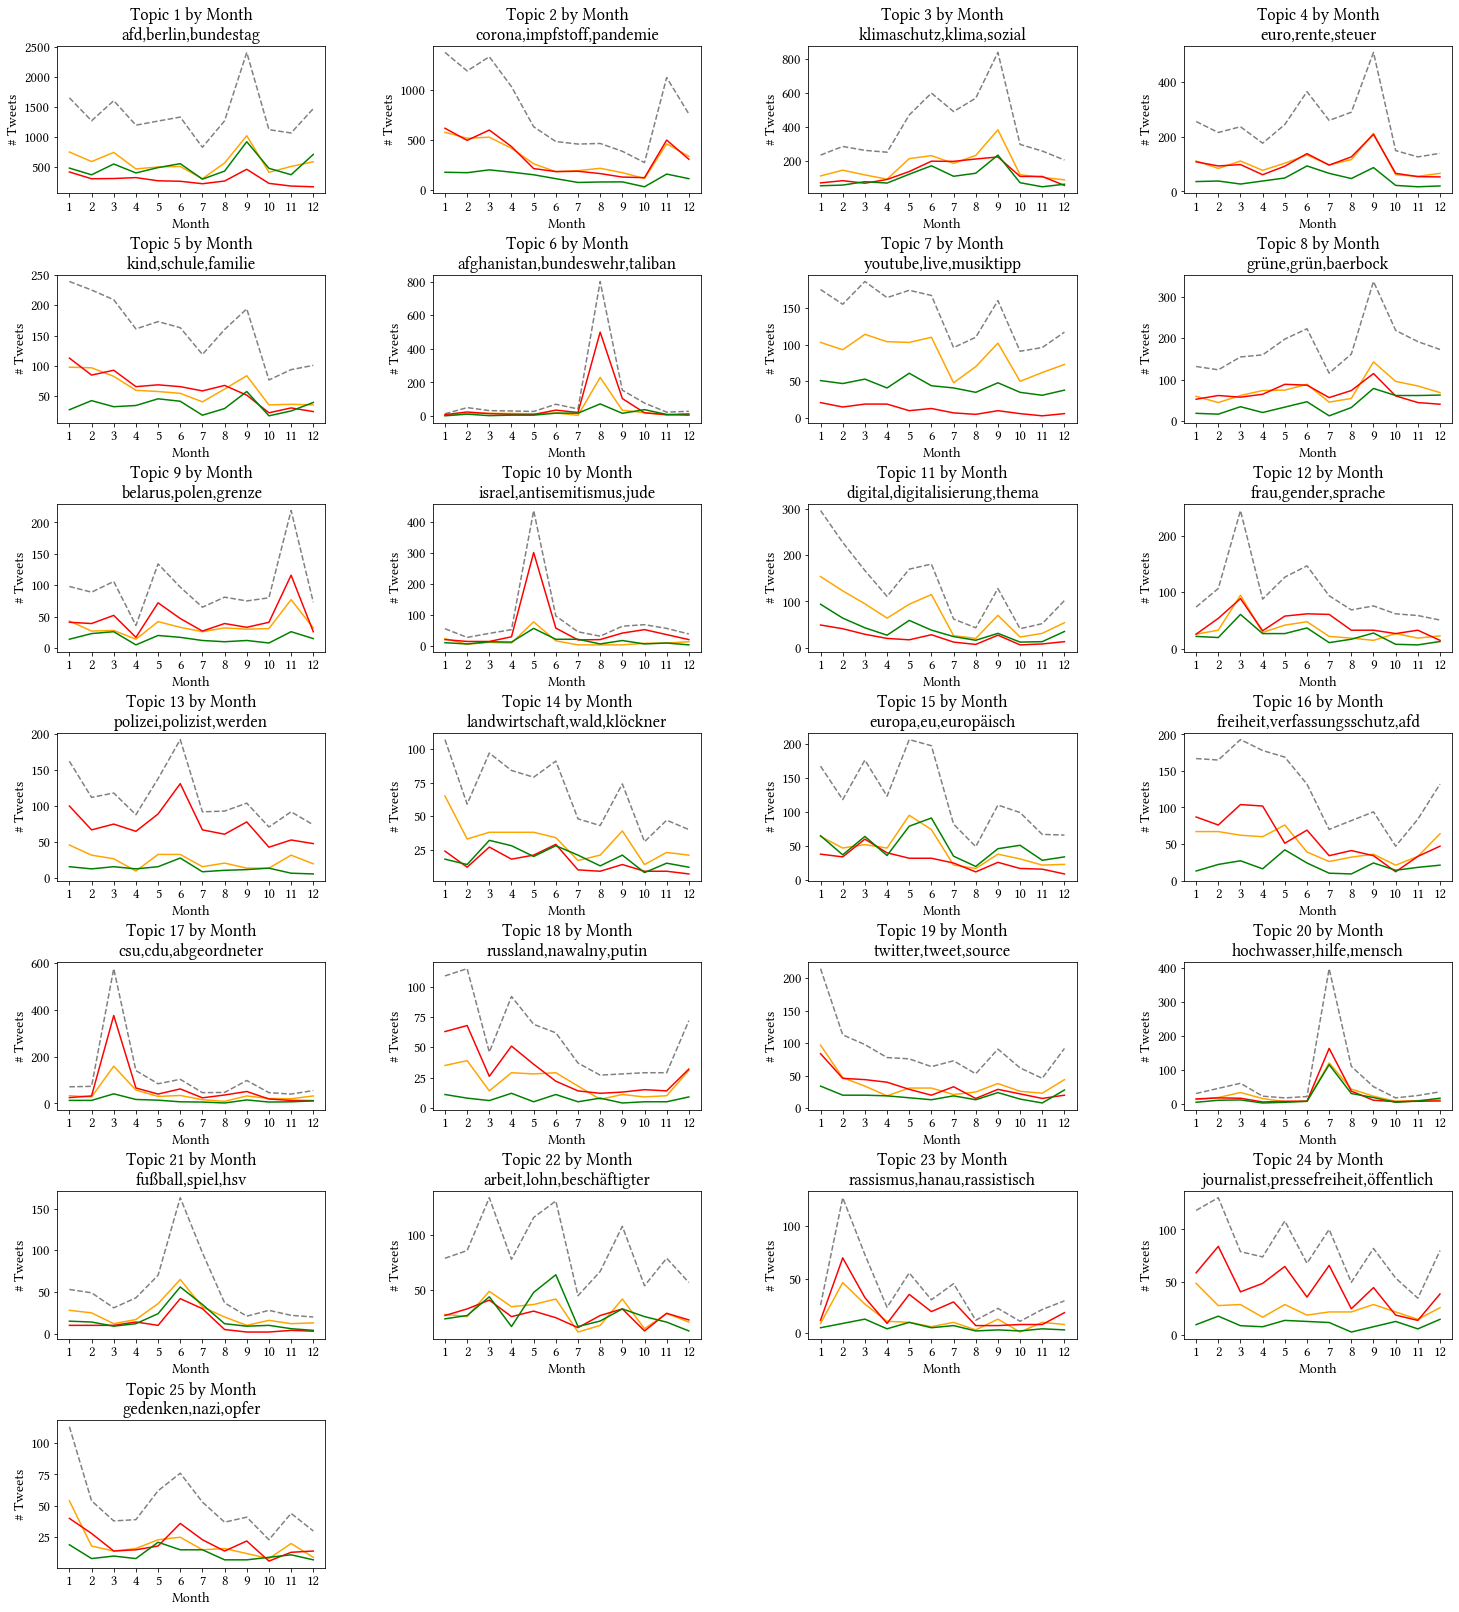

In [31]:
if 'sentiment' in df.columns:
     plot_timeseries_sentiment_subplots(df_topics, n_topics, document_info, topics_over_time, filename="results/timeseries_sentiment_subplots")

### Create Word Clouds

In [32]:
def svg_to_pdf(svg_filepath, pdf_filepath):
    drawing = svg2rlg(svg_filepath)
    renderPDF.drawToFile(drawing, pdf_filepath)

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wordcloud = WordCloud(background_color="white", max_words=1000, width=1000, height=700, font_path=FONT_PATH_WORDCLOUDS)
    wordcloud.generate_from_frequencies(text)
    
    base_path = f'wordclouds/wordcloud_topic_{topic}'
    
    # Save wordcloud as svg
    wordcloud_svg = wordcloud.to_svg(embed_font=True)
    svg_path = base_path + ".svg"
    f = open(svg_path, "w+")
    f.write(wordcloud_svg)
    f.close()

    # Save wordcloud as png
    png_path = base_path + ".png"
    wordcloud.to_file(png_path)
    
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

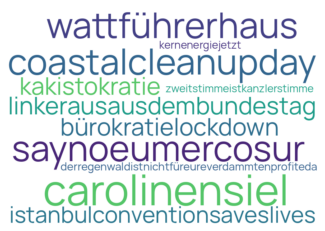

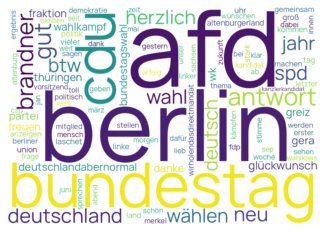

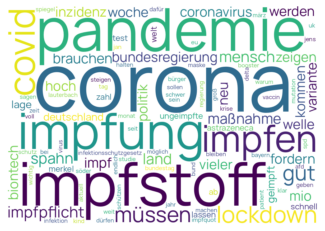

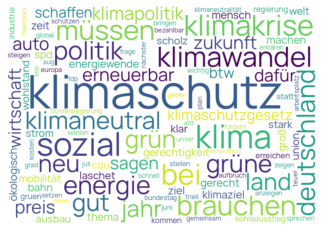

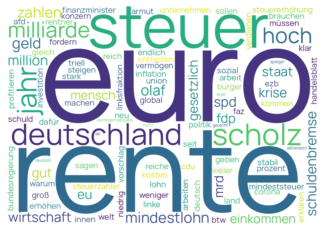

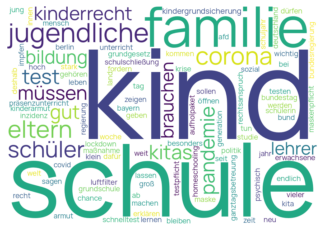

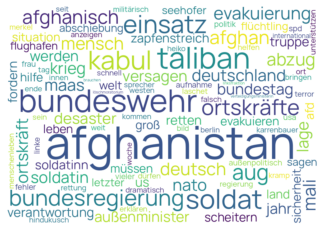

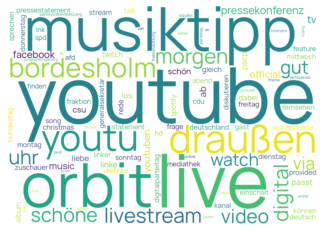

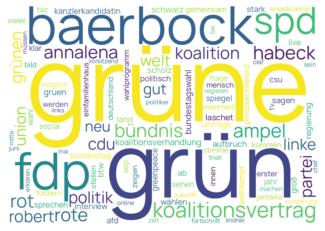

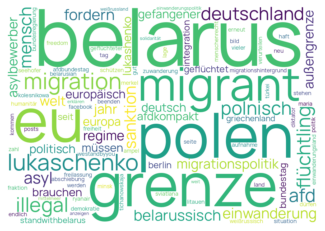

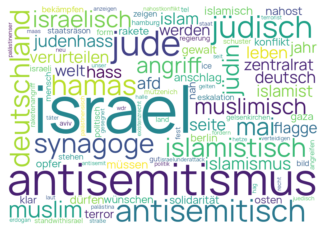

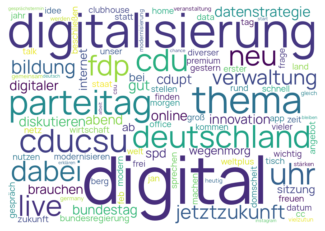

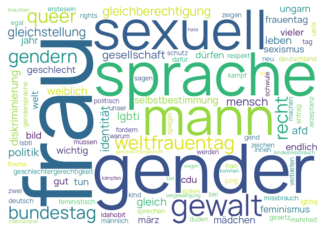

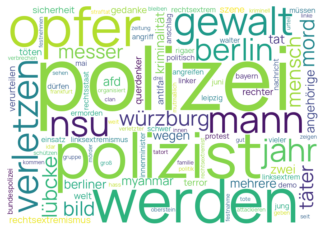

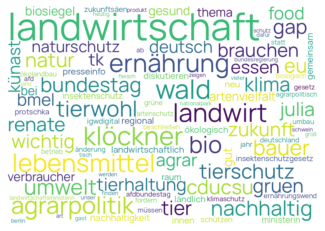

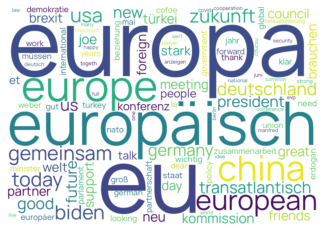

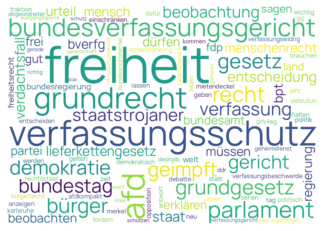

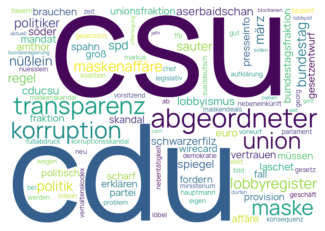

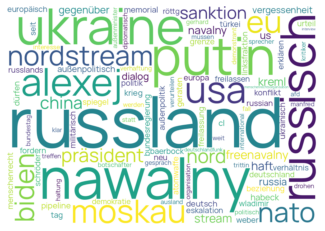

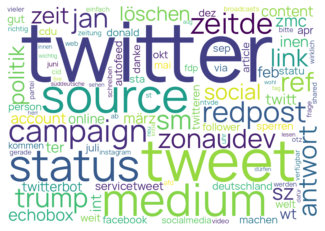

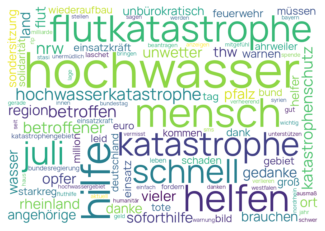

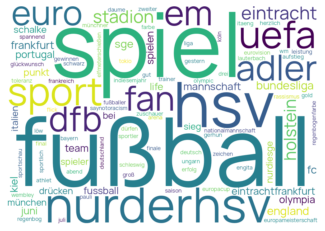

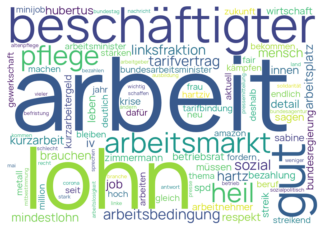

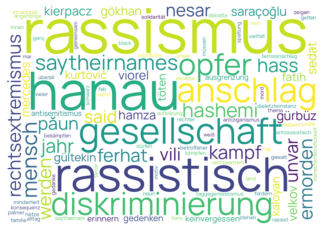

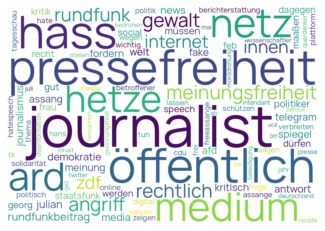

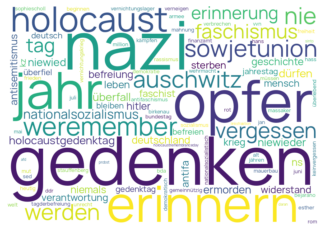

In [34]:
for topic in sorted(document_info["Topic"].unique()):
    create_wordcloud(model, topic=topic)

### Save Model

In [35]:
model.save(MODEL_OUTPUT_PATH)

/opt/conda/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [36]:
#model = BERTopic.load("politician_model")